<a href="https://colab.research.google.com/github/Evil-Tux/Diffusion-Models/blob/main/Diffusion_Models_Two.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diffusers==0.16.1 accelerate open_clip_torch transformers

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision.transforms import Compose, Resize, ToTensor, ToPILImage

from diffusers import DDPMScheduler, DDIMScheduler, DDPMPipeline, DDIMPipeline

from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import numpy as np

def plot_images(images, n=8, axs=None):
    if axs is None:
        fig, axs = plt.subplots(1, n, figsize=(10, 3))
    assert len(axs) == len(images)
    for i, img in enumerate(images):
        axs[i].axis('off')
        if isinstance(img, torch.Tensor):
            img = ToPILImage()((img/2+0.5).clamp(0, 1))
        axs[i].imshow(img.resize((64, 64), resample=Image.NEAREST), cmap='gray_r', vmin=0, vmax=255)

## UNet - What Is It?

UNet is a (neural) network shaped like the letter “U”.

![](https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/blob/main/images/hf_unit1_unet.png?raw=true)
Source: [Introduction to Diffusers - Unit 1 - HuggingFace's Diffusion Models class](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb)

UNets, like the one depicted above, use a sequence of "down blocks" to reduce the dimensions of the input image (the encoder part), and then use a sequence of "up blocks" to bring the dimensions back to their full glory (the decoder part), while making residual connections between the two sequences. They were originally developed for image segmentation tasks, but they became a basic building block of diffusion models as well.

The diffusers library offers an out-of-the-box fully configurable class called UNet2DModel that allows us to instantiate such a model that fits our needs. We will review the features this class has to offer below.

Now, we can use the UNet2DModel class to instantiate a model:

In [ ]:
from diffusers import UNet2DModel

image_size = 32

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=1,           # the number of input channels
    out_channels=1,          # the number of output channels
    layers_per_block=2,      # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        "DownBlock2D",       # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",   # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",     # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",         # a regular ResNet upsampling block
    ),
)

How big is that?

In [ ]:
model.num_parameters()/1e6

That's 18 million parameters, not so large, so it fits well our purpose here.

We'll use this model, and the scheduler, to perform a sequence of steps that belong in the training loop:

1. Fetch Clean Images
2. Generate (Full) Noise
3. Random Timesteps
4. Add Noise to Clean Images
5. Predict (Full) Noise from (Partially) Noisy Images
6. Compute Loss

First, let's create an optimizer for our model, and a loss function:

In [ ]:
#########
## NEW ##
#########
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)
loss_fn = nn.MSELoss()

num_train_timesteps = noise_scheduler.config.num_train_timesteps

### Step 1: Fetch Clean Images

Nothing new here, let’s initiate the process by loading a batch of clean images from our data loader.

In [ ]:
#########
## NEW ##
#########
composed = Compose([Resize(32), ToTensor()])
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=composed)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))
clean_images = batch[0].to(device)
plot_images(clean_images[:8])

### Step 2: Generate (Full) Noise

We've already done that as well: simply generating Gaussian noise in the same shape of our mini-batch of clean images.

In [ ]:
noise = torch.randn_like(clean_images).to(device)
plot_images(noise[:8])

### Step 3: Random Timesteps

We'd like our model to be able to handle different levels of noise added to the images, so it can perform well when we're in the reverse diffusion process predicting the image at the previous step.

Therefore, we add different amounts of noise to each image in the mini-batch by randomly choosing timesteps.

In [ ]:
bs = clean_images.shape[0]
t = torch.randint(0, num_train_timesteps, (bs,), device=device).long()
t

### Step 4: Add Noise to Clean Images

Now that we have clean images, Gaussian noise, and timesteps, it's scheduler time!

In [ ]:
noisy_images = noise_scheduler.add_noise(clean_images, noise, t)
plot_images(noisy_images[:8])

### Step 5: Predict (Full) Noise from (Partially) Noisy Images

The UNet model may return a dictionary or a tuple, so we need to unpack its predictions.

Notice that the model is supposed to predict the FULL noise, even though we'll be later on trying to iteratively predict a slightly less noisier image one step at a time.

In [ ]:
noise_pred = model(noisy_images, t, return_dict=False)[0]
plot_images(noise_pred[:8])

An untrained model surely produces noise as predictions, but then again, our model is supposed to predict noise! So, how can we tell if it's doing a good job? That's what loss functions are for!

### Step 6: Compute Loss

It just computes the mean squared error (MSE) between the generated and the predicted noise.

In [ ]:
loss = loss_fn(noise_pred, noise)
loss

There we go! We have all the diffusion-related steps (and the loss), so we're only missing the typical PyTorch training stuff (computing gradients, updating parameters, zeroing gradients) and we have ourselves a training loop.

### Training Loop

Training the UNet over 10 epochs in Google Colab may take 35 minutes or so. Therefore, as an alternative, we trained the model and uploaded the weights as a "release" in GitHub so you can download them. If you would like to move forward with the GitHub release, scroll ahead to the “Loading Trained Model” section.

Below is the code for the training loop:

In [ ]:
losses = []

for epoch in tqdm(range(3)):
    for step, batch in enumerate(train_dataloader):
        # Step 1: Fetch Clean Images
        clean_images = batch[0].to(device)

        # Step 2: Generate (Full) Noise
        noise = torch.randn_like(clean_images).to(device)

        # Step 3: Random Timesteps
        bs = clean_images.shape[0]
        t = torch.randint(0, num_train_timesteps, (bs,), device=device).long()

        # Step 4: Add Noise to Clean Images
        noisy_images = noise_scheduler.add_noise(clean_images, noise, t)

        # Step 5: Predict (Full) Noise from (Partially) Noisy Images
        noise_pred = model(noisy_images, t, return_dict=False)[0]

        # Step 6: Compute Loss
        loss = loss_fn(noise_pred, noise)

        # Regular PyTorch training loop stuff
        loss.backward(loss)
        losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

If you train the model yourself, you should get plots for the losses like those below:

![](https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/blob/main/images/diffusionhf_mnist_losses.png?raw=true)

### Loading Trained Model

Should we add some introduction here?

In [ ]:
url = 'https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/releases/download/pretrained/mnist_model.pth'
state = torch.hub.load_state_dict_from_url(url, map_location=device)
model.load_state_dict(state)

### Generating Images

It is time to try to generate some MNIST (Modified National Institute of Standards and Technology) digits out of pure noise!

Let's make some noise:

In [ ]:
torch.manual_seed(37)
sample = torch.randn(8, 1, 32, 32)
plot_images(sample)

Now, let's iteratively generate less and less noisier examples using our model to predict the noise (`epsilon`) and  the scheduler's `step()` method:

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

history = []

sample = sample.to(device)

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        epsilon = model(sample, t).sample

    sample = noise_scheduler.step(epsilon, t, sample).prev_sample

    if not (t % 200):
        history.append(sample)

In the plot below, we can check the progress after every 200 steps:

In [ ]:
fig, axs = plt.subplots(len(history), 8, figsize=(10, 5))
for i, h in enumerate(history):
    plot_images(h, axs=axs[i])

That's really cool, right? I know, it's just MNIST, we're all kinda tired of that, but still, we started with noise and nothing else!

Besides, we don't even need to write a generation loop...

### DDPM Pipeline

Hugging Face’s has pipelines to everything, and diffusion models are no exception. We can create a pipeline for denoising diffusion probabilistic models like ours (DDPMPipeline) using a trained model and the scheduler used for it, and the pipeline object does the rest:

In [ ]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

pipeline_output = image_pipe(batch_size=8)

In [ ]:
plot_images(pipeline_output.images)

Voilà! More MNIST digits!

### Denoising Diffusion Implicit Models (DDIM)

Perhaps you noticed it took quite a while to generate those images. No wonder, the denoising process is performed 1,000 times! Fortunately, you do not necessarily have to go through EVERY individual step to successfully turn pure noise into a meaningful image.

It was shown in the [Speeding Up Diffusion Sampling](https://minibatchai.com/diffusion/generative-models/text2image/sampling/2022/07/14/Diffusion_Sampling.html) paper that it is possible to take a shortcut and jump ahead, effectively skipping several steps at a time. For example, instead of 1,000 steps, we could use as few as 20-50 steps! The step numbers themselves, though, are unchaged - it looks like slicing a Python list.

In [ ]:
torch.manual_seed(37)
sample = torch.randn(8, 1, 32, 32)

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
noise_scheduler.timesteps[::50]

### Mixing & Matching

If you didn't buy into the idea of skipping several steps, let's try some mixing and matching ourselves to see if it works (spoiler alert: it does!).

Let's modify the generation loop a little bit:
- first, we slice the the timesteps array, so we're only taking every 50th step from it (resulting in 20 steps total).
- for each step in the sliced list, we do not take the `prev_sample` from the scheduler anymore, but the predicted denoised image (`pred_original_sample`) instead.
- then, we mix it with the sample from the previous iteration, using weights proportional to how far we moved in the denoising process, to get the new, updated, noisy sample to be used in the next iteration.

Notice that we're mixing it linearly for the sake of simplicity, even though our scheduler is actually following a different rule (`squaredcos_cap_v2`).

Let's see how it goes:

In [ ]:
history = []

sample = sample.to(device)

for i, t in tqdm(enumerate(noise_scheduler.timesteps[::50])):
    with torch.no_grad():
        epsilon = model(sample, t).sample

    pred_x0 = noise_scheduler.step(epsilon, t, sample).pred_original_sample

    mix_factor = 1 - t / noise_scheduler.config.num_train_timesteps
    sample = sample * (1 - mix_factor) + pred_x0 * mix_factor

    if not ((t+1) % 200):
        history.append(sample)

In [ ]:
fig, axs = plt.subplots(len(history), 8, figsize=(10, 5))
for i, h in enumerate(history):
    plot_images(h, axs=axs[i])

Not bad, right? The digits seem a bit bold, but they are clearly recognizable as digits.

Are you convinced? We hope so. Of course, we won't be mixing anything manually, we can simply use the appropriate scheduler and pipeline classes for that: `DDIMScheduler` and `DDIMPipeline`.

We may even "convert" our former DDPM scheduler into a new DDIM scheduler by calling the `from_config()` method available to all schedulers:

In [ ]:
from diffusers import DDIMPipeline, DDIMScheduler

new_scheduler = DDIMScheduler.from_config(noise_scheduler.config)
new_image_pipe = DDIMPipeline(unet=model, scheduler=new_scheduler)

Let's put our new pipeline to the test:

In [ ]:
pipeline_output = new_image_pipe(batch_size=8, num_inference_steps=20)

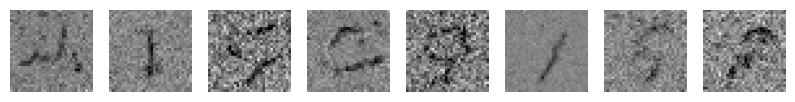

In [ ]:
plot_images(pipeline_output.images)

Hooray! That was much faster! Misson acomplished!

We developed a UNET model to predict noise through loss functions and utilized diffusers classes to “skip” denoising steps for faster image generation. In the next post in the Diffusion Model series, we’ll fine tune a pretrained model, detailing step by step how to specialize it for a specific task.